#Arabic Sentiment Analysis using different version of BERT 
( Fast AraBert, MarBert and AraBert ) and Transfer learning of Fast Arabert to Saudi Tweet


Device GPU or CPU ?

In [1]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    # !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# Install Requirements

In [2]:
!pip install  emoji==1.7
!git clone https://github.com/aub-mind/arabert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'arabert' already exists and is not an empty directory.


In [3]:
!pip install PyArabic farasapy fast-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import emoji
import regex 
import pandas as pd
import numpy as np
import os, re
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel,AutoTokenizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,mean_squared_error
from arabert.preprocess import ArabertPreprocessor




#Read Data

In [5]:
# read by default 1st sheet of an excel file
ArSarcaseData = pd.read_csv('/training_data.csv')
# print('Sample Data \n',ArSarcaseData[0])

# Preprocessing





##Clean Up Data

In [6]:
# ArSarcasesm PreProcessing
def ArSarcasesm_Preprocessing(data):
  text = []
  for line in data:  
   line = re.sub('[0-9@]', '',line)
   line = re.sub('[/:\._\?]', '',line)
   line = re.sub('[a-zA-z]', '',line)
   line = re.sub('[#[]', '',line)
   line = re.sub(']', '',line)
   line = line.rstrip().lstrip()
   text.append(line)
  return text

In [7]:
ArSarcasesm_Text = ArSarcasesm_Preprocessing(ArSarcaseData['tweet'])
ArSarcasesm_label = ArSarcaseData['sentiment']
#Map the label to be same as Model training Label  
ArSarcasesm_label = list(map(lambda x: x.replace('POS', 'positive'), ArSarcasesm_label))
ArSarcasesm_label = list(map(lambda x: x.replace('NEG', 'negative'), ArSarcasesm_label))
ArSarcasesm_label = list(map(lambda x: x.replace('NEU', 'neutral'), ArSarcasesm_label))
print('Data After Cleaning\n',ArSarcasesm_Text[0])

Data After Cleaning
 "د محمودالعلايليأرى أن الفريق أحمدشفيق رقم مهم في المعادلة السياسية المصرية ولا يمكن إغفالههل ترى أن هذا صحيح؟أربعةزائدواحد"





##Data Segmentation 

### Before Segmenation 

In [8]:
# Create Data Frame
from sklearn.model_selection import train_test_split
X_train, X_Test, y_train, y_Test =train_test_split(ArSarcasesm_Text, ArSarcasesm_label, test_size=0.2, random_state=42)
X_test, X_Val, y_test, y_Val =train_test_split(X_Test, y_Test, test_size=0.5, random_state=42)
# 
train_data = pd.DataFrame(data={'text':X_train,'label':y_train})
# 
test_data = pd.DataFrame(data={'text':X_test,'label':y_test})
# 
val_data = pd.DataFrame(data={'text':X_Val,'label':y_Val})
# 
train_data.head()

,text,label
0,"""الآناضول عبر محيطاليمن | ""الحوثيون"" يكثفون هج...",neutral
1,بيني وبينك خطوةٌ مجنونةٌفتعطفي باسم الهوى وامشيها,positive
2,"""شاهد روبرت دي نيرو يهاجم دونالد ترامب و يصفه ...",negative
3,"""اللي قرأ كل الكتب اللي شراهم من معرض الكتاب ا...",neutral
4,"""مافزنا لافي ايفون ولاشناط والحظ ماش يختي مابي...",neutral


In [9]:
test_data.head()

,text,label
0,"""أوباما وميركل ينددان بـ""الغارات الوحشية"" على ...",neutral
1,"""اليمنية| بحث سبل التعاون المشترك بين صندوق ال...",neutral
2,"""كيري متآمر كذاب و لافروف متآمر مجرم سوريا """,negative
3,"""أوباما غير راض عن قدرات الجيش الأفغانيأكد الر...",neutral
4,""" تشتهر طليطلة بحلوى ماثابان (معجون لوزوسكر و...",neutral


In [10]:
# Class = ['Train POS','Test POS','Train NEG','Test NEG','Train NEU','Test NEU']
# total = y_train.count('positive')
# Class_size = [y_train.count('positive')/len(y_train),y_Test.count('positive')/len(y_Test),
#         y_train.count('negative')/len(y_train) ,y_Test.count('negative')/len(y_Test),
#         y_train.count('neutral')/len(y_train) ,y_Test.count('neutral')/len(y_Test)]
# plt.bar(Class, Class_size, color=['yellow','brown','yellow','brown','yellow','brown'])
# plt.title('Split Train and Test Distrubition ', fontsize=18)

# plt.show()

### After Segmenation

In [11]:
# Bert PreProcessing
arabert_prep = ArabertPreprocessor(model_name= 'aubmindlab/bert-base-arabert')

train_data['text'] = train_data['text'].apply(lambda x: arabert_prep.preprocess(x) )
# 
test_data['text'] = test_data['text'].apply(lambda x: arabert_prep.preprocess(x))
# 
val_data['text'] = val_data['text'].apply(lambda x: arabert_prep.preprocess(x) )
# 
train_data.head()

[2023-02-18 21:00:55,047 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


,text,label
0,""" ال+ آناضول عبر محيطاليمن | "" ال+ حوثي +ون "" ...",neutral
1,بين +ي و+ بين ك+ خطو +ة مجنونةفتعطفي باسم ال+ ...,positive
2,""" شاهد روبرت دي نيرو يهاجم دونالد ترامب و+ يصف...",negative
3,""" اللي قرأ كل ال+ كتب اللي شرا +هم من معرض ال+...",neutral
4,""" مافزنا ل+ افي ايفون ولاشناط و+ ال+ حظ ماش يخ...",neutral


##Data distrbuation

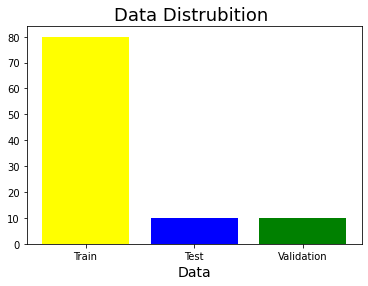

In [12]:
Data_type = ['Train','Test','Validation']
Total_Data = len(train_data)+len(test_data)+len(val_data)
Class_size = [(len(train_data)/Total_Data)*100,(len(test_data)/Total_Data)*100,(len(val_data)/Total_Data)*100]
plt.bar(Data_type, Class_size, color=['yellow','blue','green'])
plt.xlabel('Data', fontsize=14)
plt.title('Data Distrubition ', fontsize=18)
plt.show()

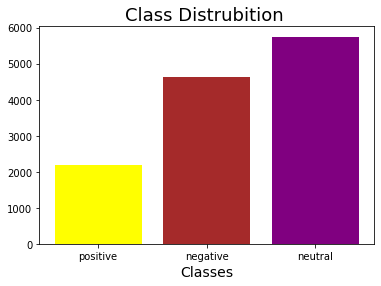

In [13]:
Sentiment_Class = ['positive','negative','neutral']
Class_size = [ArSarcasesm_label.count('positive'),
        ArSarcasesm_label.count('negative'),
        ArSarcasesm_label.count('neutral')]
plt.bar(Sentiment_Class, Class_size, color=['yellow','brown','purple'])
plt.xlabel('Classes', fontsize=14)
plt.title('Class Distrubition ', fontsize=18)

plt.show()

In [14]:
# Calcualte the Maximum Length 
Extra_Len = 6 
Max_Len = train_data['label'].str.split().str.len().max() + Extra_Len

##Prepare the data

In [15]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [16]:
# 
train_data.to_csv('data/train.csv',index=False)
test_data.to_csv('data/test.csv',index=False)
val_data.to_csv('data/dev.csv',index=False)
# 
label_map = {'positive':1,'negative':-1,'neutral':0}
# 
with open('data/labels.csv','w') as f:
  f.write("\n".join(train_data['label'].unique()))

# BERT Model

# Fast AraBERT
Fine-tune AraBERT with Fast-BERT library
https://github.com/kaushaltrivedi/fast-ber

In [17]:
import logging
from transformers import AutoTokenizer
from fast_bert.data_cls import BertDataBunch
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
from fast_bert.prediction import BertClassificationPredictor

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


##Tokenize the Data Set

![](https://miro.medium.com/max/875/0*m_kXt3uqZH9e7H4w.png)

In [18]:
tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabert')
# 
print('Vocabulary Size\t',tokenizer.vocab_size)
print('Model Length Size',tokenizer.model_max_length)
print('Model Token')
tokenizer.special_tokens_map

Vocabulary Size	 64000
Model Length Size 512
Model Token


{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

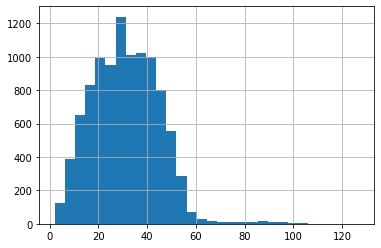

In [19]:
# get length of all the messages in the train set
seq_len = [len(tokenizer.encode(i)) for i in X_train]
pd.Series(seq_len).hist(bins = 30)

## Pretraining Phase

Create a DataBunch Object

In [20]:
databunch = BertDataBunch('./data/', './data/',
                          tokenizer=tokenizer,
                          train_file='train.csv',
                          val_file='dev.csv',
                          label_file='labels.csv',
                          text_col='text',
                          label_col='label',
                          batch_size_per_gpu=16,
                          max_seq_length=256,
                          multi_gpu=True,
                          multi_label= False,
                          model_type='bert',
                          )



Create the Learner Object


In [21]:
!mkdir output

In [22]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

device_cuda = torch.device("cuda")
metrics = [{'name': 'accuracy', 'function': accuracy}]

learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='aubmindlab/bert-base-arabert',
						metrics=metrics,
						device=device, #device_cuda
						logger=logger,
						output_dir='output',
						finetuned_wgts_path=None,
						warmup_steps=30,
						multi_gpu=False,
						is_fp16=False,
						multi_label= False,
						logging_steps=0)

Some weights of the model checkpoint at aubmindlab/bert-base-arabert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

##Fine Tuning

Training

In [23]:
Validation_history = learner.validate()
print(Validation_history['loss'])
print(Validation_history['accuracy'])

In [ ]:
learner.fit(epochs=5,
			lr=2e-5,
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_linear",
			optimizer_type="adamw")

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
learner.save_model()

Predictaion

Load the Model

In [ ]:
predictor = BertClassificationPredictor(model_path='output/model_out', 
                                        label_path='data', multi_label=False)


Predict 1 sentence

In [ ]:
print('Predict this sencnce',test_data.text[2]) 

In [ ]:
predictor.predict(test_data.text[1]) , val_data.label[1]

Predict Test Data set

In [ ]:
def predict_FastArabert(data):
  pred = []
  true = []

  for k in range(len(data.text)):
    prd = predictor.predict(data.text[k])
    true.append(label_map[data.label[k]])
  
    tab = [prd[0][1],prd[1][1],prd[2][1]]
    tab
    max = tab[0]
    indice = prd[0][0]
    for j in range(1,3):
      if tab[j]>max :
        max = tab[j]
        indice = prd[j][0]
    max , indice
    pred.append(label_map[indice])
  return pred
pred = predict_FastArabert(test_data)

In [ ]:
test_data['pred Fast arab'] = pred
test_data.head()

Evaluation

In [ ]:
def Accuracy_Loss_Evaluation(Model_Name, True_V, Predict_V):
  #Calculate Acuuracy 
  acc = accuracy_score(True_V,Predict_V)
  print('Accuarcy with ', Model_Name,acc)
  #Calculate Loss 
  Loss = mean_squared_error(True_V,Predict_V)
  print('Loss with ',Model_Name, Loss)
  return acc, Loss

def show_confusion_matrix(True_V,Predict_V):
    cm = confusion_matrix(True_V,Predict_V)
    con_matrix = pd.DataFrame(cm, index=Sentiment_Class, columns=Sentiment_Class)
    hmap = sns.heatmap(con_matrix,annot = True, fmt='' ,cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

In [ ]:
test_data['label_int'] = test_data['label'].apply(lambda x: label_map[x])
acc_FastBert,Loss_FastBert = Accuracy_Loss_Evaluation('Fast AraBert',test_data['label_int'],pred)

In [ ]:
show_confusion_matrix(test_data['label_int'], test_data['pred Fast arab'])

In [ ]:
print(classification_report(test_data['label_int'],test_data['pred Fast arab']))

In [ ]:
#  Remove the column of Fast Bert Predication to use other Model
test_data.drop(columns=['pred Fast arab'])

## Predict Saudi Data set using Fast AraBert



Read the Saudi Dataset

In [ ]:
# read by default 1st sheet of an excel file
BankData = pd.read_excel('/data_Saudi_banks.xlsx')
data_bank_distrbuation = BankData['Bank']
# 
# Saudi data PreProcessing
def SaudiData_Preprocessing(data):
  text = []
  for line in data:  
   line = re.sub('[0-9@]', '',line)
   line = re.sub('[/:\._\?]', '',line)
   line = re.sub('[a-zA-z]', '',line)
   line = re.sub('[#[]', '',line)
   line = re.sub(']', '',line)
   line = line.rstrip().lstrip()
   text.append(line)
  return text
Saudi_Text = SaudiData_Preprocessing(BankData['Tweet'])
Saudi_label = BankData['Final annotation']
#Map the label to be same as Model training Label  
Saudi_label = list(map(lambda x: x.replace('POS', 'positive'), Saudi_label))
Saudi_label = list(map(lambda x: x.replace('NEG', 'negative'), Saudi_label))
Saudi_label = list(map(lambda x: x.replace('NEU', 'neutral'), Saudi_label))

In [ ]:
# Saudi Data Segmentation 
Saudi_data = pd.DataFrame(data={'text':Saudi_Text,'label':Saudi_label})
Saudi_data['text'] = Saudi_data['text'].apply(lambda x: arabert_prep.preprocess(x) )

Prediaction 

In [ ]:
Saudi_pred = predict_FastArabert(Saudi_data)

In [ ]:
Saudi_data['pred Saudi'] = Saudi_pred
Saudi_data.head()

Evaluation

In [ ]:
Saudi_data['label_int'] = Saudi_data['label'].apply(lambda x: label_map[x])
acc_FastBert_Saudi, Loss_FastBert_Saudi = Accuracy_Loss_Evaluation('Fast AraBert',Saudi_data['label_int'],Saudi_pred)

In [ ]:
show_confusion_matrix(Saudi_data['label_int'], Saudi_data['pred Saudi'])

In [ ]:
print(classification_report(Saudi_data['label_int'],Saudi_data['pred Saudi']))

Negative case labeled as Positive 

In [ ]:
Saudi_data[Saudi_data['label_int']!= Saudi_data['pred Saudi']].head()

Positive case labeled as Negative 

In [ ]:
Saudi_data[(Saudi_data['label_int']==1) & (Saudi_data['pred Saudi'] == -1)].head()

## Comparision SemEval & Saudi DataSet

In [ ]:
Results = pd.DataFrame(data={'SemEval':[acc_FastBert *100,Loss_FastBert],'Saudi':[acc_FastBert_Saudi*100,Loss_FastBert_Saudi]})
Results.index = ['Accuracy', 'Loss']
Results.head()


# MarBERT

In [19]:
import random, gc
import numpy as np
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from transformers import Trainer , TrainingArguments
from transformers import  AutoModelForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score

Define BERT Model Data Set

In [20]:
Model_Used = "UBC-NLP/MARBERT"
Task_Name = "classification"

class Dataset:
    def __init__(
        self,
        name,
        train,
        test,
        label_list,
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list
        
class BERTModelDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(BERTModelDataset).__init__()
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
  
    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
    
      encoded_review = self.tokenizer.encode_plus(
      text,
      max_length= self.max_len,
      add_special_tokens= True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      truncation='longest_first',
      return_attention_mask=True,
      return_tensors='pt'
    )
      input_ids = encoded_review['input_ids'].to(device)
      attention_mask = encoded_review['attention_mask'].to(device)
      
      return InputFeatures(input_ids=input_ids.flatten(), attention_mask=attention_mask.flatten(), label=self.label_map[self.target[item]])

In [21]:

Rand_Seed = 42 
Use_Train_Extended_Data = True


label_list = ['positive','negative','neutral']
label_map_Mar = {'positive':1,'negative':2,'neutral':0}


data_set = Dataset( "Sem", train_data, val_data, label_list )

train_dataset = BERTModelDataset(train_data['text'].to_list(),
                                 train_data['label'].to_list(),Model_Used,Max_Len,label_map_Mar)

evaluation_dataset = BERTModelDataset(val_data['text'].to_list(),
                                      val_data['label'].to_list(),Model_Used,Max_Len,label_map_Mar)



Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Defining Needed Methods for training and evaluation

In [22]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(Model_Used, return_dict=True, num_labels=len(label_map_Mar))

def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))

  macro_f1_pos_neg = f1_score(p.label_ids,preds,average='macro',labels=[0,1,2])
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'macro_f1' : macro_f1,
      'macro_f1_pos_neg' : macro_f1_pos_neg,  
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


Define Training Arguments

In [23]:
#define training arguments
training_args = TrainingArguments("./train")
training_args.lr_scheduler_type = 'cosine'
training_args.evaluate_during_training = True
training_args.adam_epsilon =1e-8 
if Use_Train_Extended_Data :
    training_args.learning_rate = 1.215e-05 # use this with extended data
else:
    training_args.learning_rate = 1.78255000000000001e-05 # use this with org data  
training_args.fp16 = True
training_args.per_device_train_batch_size = 16 #64 
training_args.per_device_eval_batch_size = 16 # 64 
training_args.gradient_accumulation_steps = 2
training_args.num_train_epochs= 5
training_args.warmup_steps = 0 
training_args.evaluation_strategy = EvaluationStrategy.EPOCH
training_args.logging_steps = 200
training_args.save_steps = 100000 
training_args.seed = Rand_Seed 
training_args.disable_tqdm = False

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


 Build Model

In [24]:
training_args.dataloader_pin_memory = False
gc.collect()
torch.cuda.empty_cache()
set_seed(Rand_Seed) 

trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset= evaluation_dataset,
    compute_metrics=compute_metrics
)

print(training_args.seed)

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at U

42


/usr/local/lib/python3.8/dist-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training

In [25]:
print(Max_Len)
print(training_args.learning_rate)
print(training_args.adam_epsilon)
print(training_args.warmup_steps)
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10038
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 1570
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to No

7
1.215e-05
1e-08
0


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1570, training_loss=0.6888589263721636, metrics={'train_runtime': 7761.0104, 'train_samples_per_second': 6.467, 'train_steps_per_second': 0.202, 'total_flos': 180546166114020.0, 'train_loss': 0.6888589263721636, 'epoch': 5.0})

Predication

In [26]:
# first define the predection method
def predict(text, tokenizer):
 
  encoded_review = tokenizer.encode_plus(
    text,
    max_length=Max_Len,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True, #True,
    truncation='longest_first',
    return_attention_mask=True,
    return_tensors='pt'
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
    

  output = trainer.model(input_ids, attention_mask)
  _, prediction = torch.max(output[0], dim=1)
  return prediction[0]

#then lets play !

tokenizer = AutoTokenizer.from_pretrained(Model_Used)

prediction_list = []
i = 0
for tweet in test_data['text']:
    id = test_data['label'][i]
  
    pre = predict(tweet,tokenizer)
    
    # pre_txt = label_list[pre]
    
    # if pre_txt == 'positive': pre_txt = 1
    # if pre_txt == 'negative': pre_txt = 2
    # if pre_txt == 'neutral': pre_txt = 0
    prediction_list.append(pre)
    
    i = i + 1

loading configuration file https://huggingface.co/UBC-NLP/MARBERT/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/149fd0f2228ba9e18736429c365b97eb4a2af1c198b1e068b99815d78d3d9e25.897c52772d161fa08b3d031e0e548347e8ae1f81959cd6e58ccf096423ca5a11
Model config BertConfig {
  "_name_or_path": "UBC-NLP/MARBERT",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_ty

In [27]:
test_data['pred MarBert'] = [label_list[x] for x in  prediction_list]
test_data.head()

,text,label,pred MarBert
0,""" أوباما و+ ميركل ينددان ب+ "" ال+ غار +ات ال+ ...",neutral,positive
1,""" ال+ يمني +ة | بحث سبل ال+ تعاون ال+ مشترك بي...",neutral,positive
2,""" كيري متآمر كذاب و+ لافروف متآمر مجرم سوريا """,negative,neutral
3,""" أوباما غير راض عن قدر +ات ال+ جيش ال+ أفغاني...",neutral,positive
4,""" تشتهر طليطل +ة ب+ حلوى ماثابان ( معجون لوزوس...",neutral,positive


Evaluation

In [28]:
test_data['label int'] = test_data['label'].apply(lambda x: label_map_Mar[x])
acc_MarBert,Loss_MarBert = Accuracy_Loss_Evaluation('MarBert',test_data['label int'],prediction_list)


Accuarcy with  MarBert 0.6254980079681275
Loss with  MarBert 0.9673306772908367


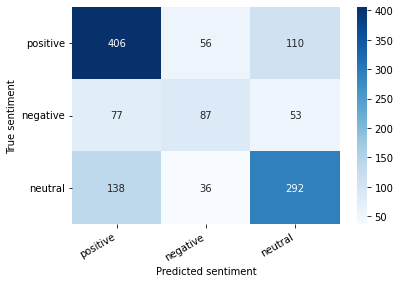

In [29]:
show_confusion_matrix(test_data['label int'], prediction_list)

MisMatch Data

Neutral Case labeled as Positive




In [30]:
test_data[(test_data['label']=='neutral') & (test_data['pred MarBert'] == 'positive')].head()

,text,label,pred MarBert,label int
0,""" أوباما و+ ميركل ينددان ب+ "" ال+ غار +ات ال+ ...",neutral,positive,0
1,""" ال+ يمني +ة | بحث سبل ال+ تعاون ال+ مشترك بي...",neutral,positive,0
3,""" أوباما غير راض عن قدر +ات ال+ جيش ال+ أفغاني...",neutral,positive,0
4,""" تشتهر طليطل +ة ب+ حلوى ماثابان ( معجون لوزوس...",neutral,positive,0
5,""" فيديو حصري ملكةالمسرح ميريامفارس من حفل زفاف...",neutral,positive,0


Positive Case labeled as Neutral


In [31]:
test_data[(test_data['label']=='positive') & (test_data['pred MarBert'] == 'neutral')].head()

,text,label,pred MarBert,label int
15,مع ال+ شخص ال+ صح ? ?,positive,neutral,1
64,""" لقد قضي ال+ أمر يا داعشفقد جائ +كم أصحاب ال+...",positive,neutral,1
150,ال+ شعب ال+ مصري أجمل حاج +ه في +ه +ان في وسط ...,positive,neutral,1
165,ال+ عواجي زار هزازي في سرير مرض +ه ال+ أبيض ف+...,positive,neutral,1
185,من أنواع سخري +ة ال+ قدر ؛ أن أقرر أن اتخطاك و...,positive,neutral,1


In [32]:
#  Remove the column of Fast Bert Predication to use other Model
test_data.drop(columns=['pred MarBert','label int'])

,text,label
0,""" أوباما و+ ميركل ينددان ب+ "" ال+ غار +ات ال+ ...",neutral
1,""" ال+ يمني +ة | بحث سبل ال+ تعاون ال+ مشترك بي...",neutral
2,""" كيري متآمر كذاب و+ لافروف متآمر مجرم سوريا """,negative
3,""" أوباما غير راض عن قدر +ات ال+ جيش ال+ أفغاني...",neutral
4,""" تشتهر طليطل +ة ب+ حلوى ماثابان ( معجون لوزوس...",neutral
...,...,...
1250,ال+ مضحك إن ال+ صفح +ات ال+ إسلامي +ة جري +ت و...,negative
1251,""" لقد تاجر +وا ب+ +نا يا صديق +ي """,negative
1252,""" تظاهر +ات أحوازية ضد إيران ل+ مصادر +ت +ها أ...",neutral
1253,مصرالليلة فياض ال+ انقلابي +ون فعل +وا ما لم ي...,negative


# AraBERT

In [33]:
from transformers import AutoModel
import torch.nn as nn
from transformers import BertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim import SparseAdam, Adam
import time
import random
import torch

Tokenizer

In [34]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic")

https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpnu7ga1ox


Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

storing https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/ca7ed210fa3eec2abd0578113599200ecf45a827a37404a58b5628300ce56b2a.1788df22ba1a6817edb607a56efa931ee13ebad3b3500e58029a8f4e6d799a29
creating metadata file for /root/.cache/huggingface/transformers/ca7ed210fa3eec2abd0578113599200ecf45a827a37404a58b5628300ce56b2a.1788df22ba1a6817edb607a56efa931ee13ebad3b3500e58029a8f4e6d799a29
https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp2ifpf_j4


Downloading:   0%|          | 0.00/509 [00:00<?, ?B/s]

storing https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/bc1079ed9c2e0cceb4310a1f5652aa861ed6b32a4c0cafd10f2d7307a40ac9e5.54a68e8a5d7bd76555f26d5c4ee0fba2f6aae857d8377511d71f4b9a001561fc
creating metadata file for /root/.cache/huggingface/transformers/bc1079ed9c2e0cceb4310a1f5652aa861ed6b32a4c0cafd10f2d7307a40ac9e5.54a68e8a5d7bd76555f26d5c4ee0fba2f6aae857d8377511d71f4b9a001561fc
loading configuration file https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/bc1079ed9c2e0cceb4310a1f5652aa861ed6b32a4c0cafd10f2d7307a40ac9e5.54a68e8a5d7bd76555f26d5c4ee0fba2f6aae857d8377511d71f4b9a001561fc
Model config BertConfig {
  "_name_or_path": "asafaya/bert-mini-arabic",
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

storing https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/247eee0906935a2a74c697c05ec955ec1487e6d310aa831338694a8b1baf717e.63883f8c719f41c4f4feb08f611fd3bbe39009b245fef4ec83de8a16821590be
creating metadata file for /root/.cache/huggingface/transformers/247eee0906935a2a74c697c05ec955ec1487e6d310aa831338694a8b1baf717e.63883f8c719f41c4f4feb08f611fd3bbe39009b245fef4ec83de8a16821590be
https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpkft60nrm


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/4452d4bc082e58ed5693b81fdafa30c92a7009b828237682280b6d40d0d7c1f1.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/4452d4bc082e58ed5693b81fdafa30c92a7009b828237682280b6d40d0d7c1f1.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/247eee0906935a2a74c697c05ec955ec1487e6d310aa831338694a8b1baf717e.63883f8c719f41c4f4feb08f611fd3bbe39009b245fef4ec83de8a16821590be
loading file https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/asafaya/ber

Define BERT dataset

In [35]:
# Create a function to tokenize a set of texts
import emoji
import unicodedata
def AraBert_DataSet(data, version="mini"):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

    # For every sentence...
    for i,sent in enumerate(data):
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=data[i], 
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=Max_Len,                  # Max length to truncate/pad
            padding='max_length',        # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,     # Return attention mask
            truncation = True 
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [36]:
print('Tokenizing data...')
train_inputs, train_masks = AraBert_DataSet(train_data['text'])
val_inputs, val_masks = AraBert_DataSet(val_data['text'])

Tokenizing data...


loading configuration file https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/bc1079ed9c2e0cceb4310a1f5652aa861ed6b32a4c0cafd10f2d7307a40ac9e5.54a68e8a5d7bd76555f26d5c4ee0fba2f6aae857d8377511d71f4b9a001561fc
Model config BertConfig {
  "_name_or_path": "asafaya/bert-mini-arabic",
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading f

Create Data loader

In [37]:
train_data['label'] = train_data['label'].replace(['positive','negative','neutral'],[0,2,1])
val_data['label'] = val_data['label'].replace(['positive','negative','neutral'],[0,2,1])

train_labels = torch.tensor(train_data['label'])
val_labels = torch.tensor(val_data['label'])

# For fine-tuning BERT
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Define model 

In [38]:
%%time
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False, version="mini"):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in = 256 if version == "mini" else 768
        H, D_out = 50, 3 # 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoModel.from_pretrained("asafaya/bert-base-arabic")
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 261 µs, sys: 0 ns, total: 261 µs
Wall time: 461 µs


In [39]:

def initialize_model(epochs=4, version="mini"):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False, version=version)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(params=list(bert_classifier.parameters()),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

Define model train and evaluate functions

In [40]:

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Training

In [41]:
Rand_Seed =2020
set_seed(Rand_Seed) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

loading configuration file https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/bc1079ed9c2e0cceb4310a1f5652aa861ed6b32a4c0cafd10f2d7307a40ac9e5.54a68e8a5d7bd76555f26d5c4ee0fba2f6aae857d8377511d71f4b9a001561fc
Model config BertConfig {
  "_name_or_path": "asafaya/bert-mini-arabic",
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

https://h

Downloading:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

storing https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/73d150318575e7ee59c7c9174cdcac9b14423c0147eef73759548053efd310b7.d7f7626458ceed21069e9826e25cf0b31dd79639413fee592a764118dedd56ac
creating metadata file for /root/.cache/huggingface/transformers/73d150318575e7ee59c7c9174cdcac9b14423c0147eef73759548053efd310b7.d7f7626458ceed21069e9826e25cf0b31dd79639413fee592a764118dedd56ac
loading weights file https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/73d150318575e7ee59c7c9174cdcac9b14423c0147eef73759548053efd310b7.d7f7626458ceed21069e9826e25cf0b31dd79639413fee592a764118dedd56ac
Some weights of the model checkpoint at asafaya/bert-mini-arabic were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weig

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.119521   |     -      |     -     |   4.05   
   1    |   40    |   1.038017   |     -      |     -     |   4.72   
   1    |   60    |   1.036315   |     -      |     -     |   4.26   
   1    |   80    |   1.011350   |     -      |     -     |   3.73   
   1    |   100   |   0.973847   |     -      |     -     |   3.73   
   1    |   120   |   0.985143   |     -      |     -     |   5.24   
   1    |   140   |   0.975443   |     -      |     -     |   3.79   
   1    |   160   |   1.006122   |     -      |     -     |   3.73   
   1    |   180   |   0.990537   |     -      |     -     |   4.15   
   1    |   200   |   0.969350   |     -      |     -     |   4.73   
   1    |   220   |   0.972748   |     -      |     -     |   3.71   
   1    |   240   |   1.033575   |     -      |     -     |   3.75   


Predication 

In [42]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [43]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = AraBert_DataSet(test_data['text'])

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


loading configuration file https://huggingface.co/asafaya/bert-mini-arabic/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/bc1079ed9c2e0cceb4310a1f5652aa861ed6b32a4c0cafd10f2d7307a40ac9e5.54a68e8a5d7bd76555f26d5c4ee0fba2f6aae857d8377511d71f4b9a001561fc
Model config BertConfig {
  "_name_or_path": "asafaya/bert-mini-arabic",
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading f

In [44]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
# Get predictions from the probabilities
preds = np.argmax(probs, axis=1)

In [45]:
test_data['pred AraBert'] =  preds
test_data.head()

,text,label,pred MarBert,label int,pred AraBert
0,""" أوباما و+ ميركل ينددان ب+ "" ال+ غار +ات ال+ ...",neutral,positive,0,1
1,""" ال+ يمني +ة | بحث سبل ال+ تعاون ال+ مشترك بي...",neutral,positive,0,1
2,""" كيري متآمر كذاب و+ لافروف متآمر مجرم سوريا """,negative,neutral,2,2
3,""" أوباما غير راض عن قدر +ات ال+ جيش ال+ أفغاني...",neutral,positive,0,1
4,""" تشتهر طليطل +ة ب+ حلوى ماثابان ( معجون لوزوس...",neutral,positive,0,1


In [46]:
label_map_ara = {'positive':0,'negative':2,'neutral':1}
test_data['label_int'] = test_data['label'].apply(lambda x: label_map_ara[x])
acc_AraBert,Loss_AraBert = Accuracy_Loss_Evaluation('AraBert',test_data['label_int'],preds)

Accuarcy with  AraBert 0.6119521912350597
Loss with  AraBert 0.7179282868525897


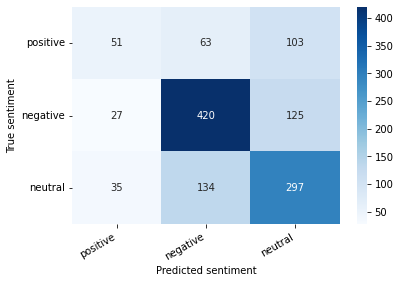

In [47]:
show_confusion_matrix(test_data['label_int'], test_data['pred AraBert'])